# Importing Libraries

### Installing Tourchvision

In [ ]:
pip install torch torchvision torchaudio

# Read dataset

In [ ]:
import os
import torch
import random
from PIL import Image
from torchvision.io import read_image
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

### Dataset Class

In [ ]:
class ISIC2018Dataset(data.Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1:].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

### Check First Rows

In [ ]:
import pandas as pd

# Read the CSV file directly from the desktop
train_annotations_file = "ISIC2018_Task3_Training_GroundTruth.csv"
ground_truth = pd.read_csv(train_annotations_file)

# Check the first few rows of the DataFrame
print(ground_truth.head())

### Plot Data

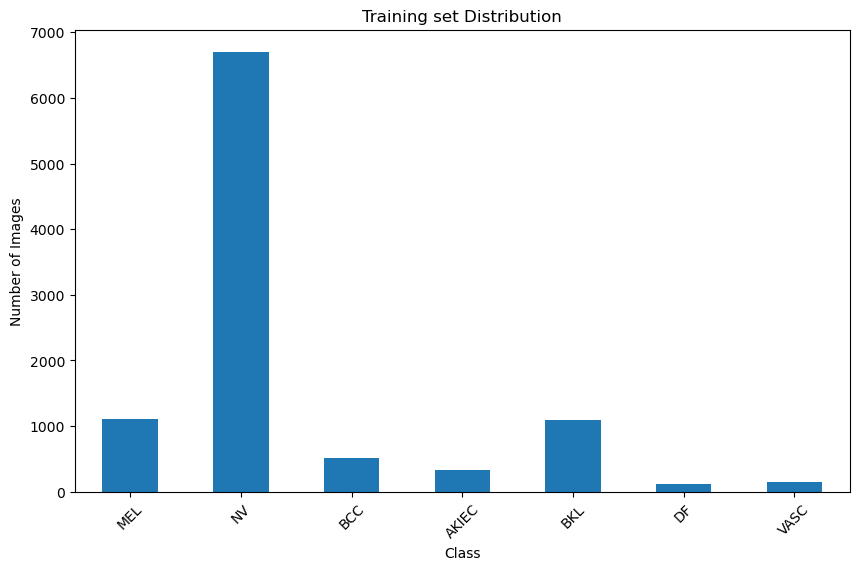

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Get the path to the desktop
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')

# Specify the file name
file_name = "ISIC2018_Task3_Training_GroundTruth.csv"

# Construct the full file path
file_path = os.path.join(desktop_path, file_name)

print("File path:", file_path)  # Print file path for debugging

# Check if the file exists
if not os.path.exists(file_path):
    print("File does not exist:", file_path)
else:
    # Read the CSV file
    ground_truth = pd.read_csv(file_path)

    # Calculate class distribution
    class_distribution = ground_truth.drop(columns=['image']).sum()

    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    class_distribution.plot(kind='bar')
    plt.title('Training Set Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

### Plot Validation Set

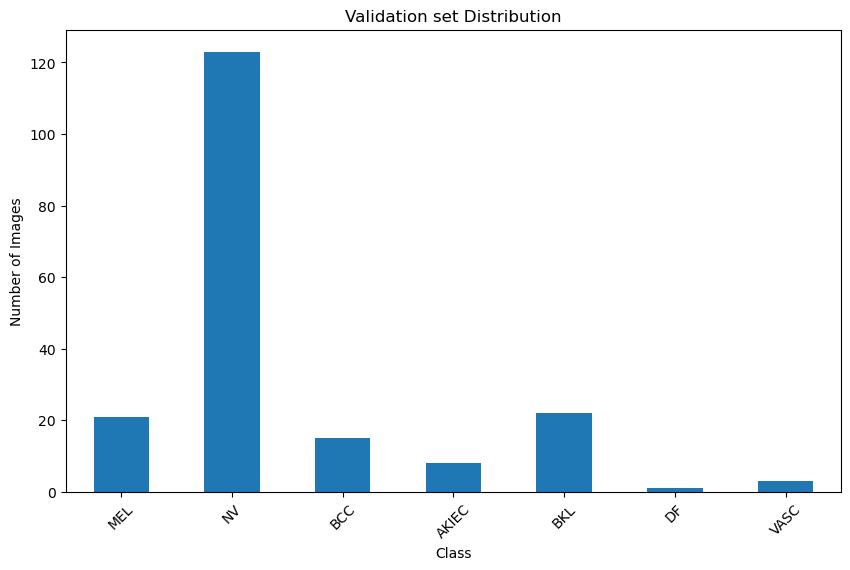

In [ ]:
# Read the CSV file
valid_annotations_file = "ISIC2018_Task3_Validation_GroundTruth.csv"
ground_truth = pd.read_csv(valid_annotations_file)

class_distribution = ground_truth.drop(columns=['image']).sum()

# Plot the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Validation set Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Dealing with Imbalanced Data

### Install previous version of Numpy

In [ ]:
pip install numpy==1.16.5

# Preprocessing

In [ ]:
import numpy as np
from sklearn.utils import resample
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn.functional as F

# Step 1: Resampling
#'ground_truth' is the DataFrame containing the ground truth labels

# Calculates the number of instances in each class
class_counts = ground_truth.drop(columns=['image']).sum()

# Identifies minority and majority classes
minority_classes = class_counts[class_counts == class_counts.min()].index
majority_classes = class_counts[class_counts == class_counts.max()].index

# Oversample minority classes
oversampled_data = []
for cls in minority_classes:
    cls_data = ground_truth[ground_truth[cls] == 1]
    oversampled_cls_data = resample(cls_data, replace=True, n_samples=len(ground_truth), random_state=42)
    oversampled_data.append(oversampled_cls_data)
oversampled_data = pd.concat(oversampled_data)

# Undersample majority classes
undersampled_data = []
for cls in majority_classes:
    cls_data = ground_truth[ground_truth[cls] == 1]
    undersampled_cls_data = resample(cls_data, replace=False, n_samples=len(cls_data)//2, random_state=42)
    undersampled_data.append(undersampled_cls_data)
undersampled_data = pd.concat(undersampled_data)

# Combine oversampled minority classes and undersampled majority classes
balanced_data = pd.concat([oversampled_data] + [undersampled_data])

# Step 2: Convert DataFrame to PyTorch DataLoader
# Custom Dataset class and it accepts 'balanced_data' as input

# Calculate class weights for loss function
class_weights = 1 / class_counts

# Define sampler with class weights
weights = class_weights[balanced_data.drop(columns=['image']).values.argmax(axis=1)]
sampler = WeightedRandomSampler(weights, len(balanced_data), replacement=True)

# Create DataLoader with the custom sampler
batch_size = 32  # Adjust as needed
data_loader = DataLoader(dataset=balanced_data, batch_size=batch_size, sampler=sampler)

# Step 3: Modify loss function
# Custom model and cross-entropy loss function

# Define custom loss function
def custom_loss(output, target):
    # Assuming output is the model's predictions and target is the ground truth
    loss = F.cross_entropy(output, target, weight=torch.tensor(class_weights.values).float())
    return loss

# Train model using the DataLoader and custom loss function

### Getting File Directory

In [ ]:
folder_name = "ISIC2018_Task3_Training_Input"
folder_path = os.path.join(current_dir, folder_name)
print(folder_path)

# Displaying some data

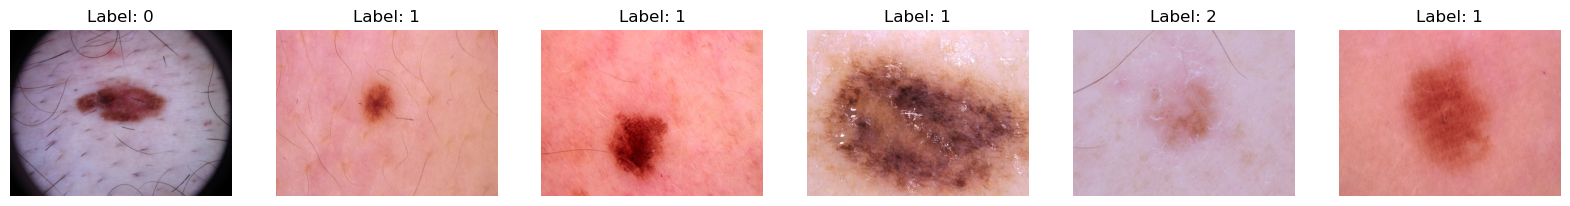

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Training set
# Path to the folder containing the images
train_img_dir = "C:/Users/Levy/Desktop/ISIC2018_Task3_Training_Input"
train_annotations_file = "C:/Users/Levy/Desktop/ISIC2018_Task3_Training_GroundTruth.csv"
train_dataset = ISIC2018Dataset(img_dir=train_img_dir, annotations_file=train_annotations_file, transform=transforms.ToTensor())

def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    indices = random.sample(range(len(dataset)), num_images)
    for i, ax in enumerate(axes.flat):
        image, label = dataset[indices[i]]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
show_images(train_dataset, num_images=6)

## Loading Dataset

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class ISIC2018Dataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_dir = img_dir
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name)
        label = self.annotations.iloc[idx, 1:].values.astype('float')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Training set
train_img_dir = "C:/Users/Levy/Desktop/ISIC2018_Task3_Training_Input"
train_annotations_file = os.path.join(train_img_dir, "ISIC2018_Task3_Training_GroundTruth.csv")
train_dataset = ISIC2018Dataset(img_dir=train_img_dir, annotations_file=train_annotations_file, transform=transform)

# Validation set
valid_img_dir = "C:/Users/Levy/Desktop/ISIC2018_Task3_Validation_Input"
valid_annotations_file = os.path.join(valid_img_dir, "ISIC2018_Task3_Validation_GroundTruth.csv")
valid_dataset = ISIC2018Dataset(img_dir=valid_img_dir, annotations_file=valid_annotations_file, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

### Installing Tourchvision (Newer Version)

In [ ]:
pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

## Transfer processing to GPU instead of CPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)
inputs, labels = inputs.to(device), labels.to(device)

## Hyperparameters


In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image

class ISIC2018Dataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_dir = img_dir
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0] + '.jpg')
        try:
            image = Image.open(img_name)
        except FileNotFoundError:
            print(f"Image file '{img_name}' not found. Skipping...")
            return None, None
        label = self.annotations.iloc[idx, 1:].values.astype('float')
        if self.transform:
            image = self.transform(image)
        return image, label

# Custom DataLoader that skips missing files
class CustomDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, collate_fn=None,
                 pin_memory=False, drop_last=False, timeout=0,
                 worker_init_fn=None):
        super().__init__(dataset, batch_size, shuffle, sampler, batch_sampler,
                         num_workers, collate_fn, pin_memory, drop_last, timeout,
                         worker_init_fn)

    def __iter__(self):
        for batch in super().__iter__():
            images, labels = batch
            valid_indices = [i for i, img in enumerate(images) if img is not None]
            if len(valid_indices) > 0:
                yield [images[i] for i in valid_indices], labels[valid_indices]

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Initialize the model, criterion, and optimizer as before
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 classes for ISIC2018
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

Using device: cpu


/Users/abhusal/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Failed to locate GPU and used CPU instead

## Training Loop

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=200, patience=10):
    best_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}')

        if val_loss < best_loss:
            print(f'Validation loss decreased from {best_loss} to {val_loss}. Saving model...')
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

# Model Training

In [ ]:
# Only change it to True when retraining the network is needed.
Train_mode = False
if Train_mode:
    train_model(model, criterion, optimizer, train_loader, valid_loader)

# Evaluation

### Load Best Model

In [ ]:
# Load the model state dictionary
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))

# Move the model to the appropriate device
model = model.to(device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
model = model.to(torch.device('cpu'))  # Ensure the model is on the CPU

### Load The Test Data

In [ ]:
# Test set
test_img_dir = "C:/Users/Levy/Desktop/ISIC2018_Task3_Training_Input"
test_annotations_file = "C:/Users/Levy/Desktop/ISIC2018_Task3_Training_GroundTruth.csv"
test_dataset = ISIC2018Dataset(img_dir=test_img_dir, annotations_file=test_annotations_file, transform=transform)

# Data loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Evaluation and Results

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def evaluate_model(model, data_loader):
    true_labels = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

# Classification
    report = classification_report(true_labels, predictions, output_dict=True)

 # Return metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }

# Function
results = evaluate_model(model, test_loader)

# Calculations
    conf_matrix = confusion_matrix(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    cohen_kappa = cohen_kappa_score(true_labels, predictions)

# Print the results
print("\nAccuracy:", results['accuracy'])
print("Precision:", results['precision'])
print("Recall:", results['recall'])
print("F1-score:", results['f1_score'])

Confusion Matrix:
[[ 55  28   2   2  11   1   0]
 [ 16 641   5   5  22   0   0]
 [  3   2  33  10  10   1   0]
 [  3   2   5  22   3   0   0]
 [ 14  21   1  11 101   0   0]
 [  0   9   1   2   2   9   0]
 [  0   4   3   2   0   1  13]]

Accuracy: 0.8122676579925651
Precision: 0.8162517762155655
Recall: 0.8122676579925651
F1-score: 0.8105748170279511
Cohen's Kappa: 0.6572691851013204

Classification Report:
 {'0': {'precision': 0.6043956043956044, 'recall': 0.5555555555555556, 'f1-score': 0.5789473684210527, 'support': 99.0}, '1': {'precision': 0.9066478076379066, 'recall': 0.93033381712627, 'f1-score': 0.9183381088825214, 'support': 689.0}, '2': {'precision': 0.66, 'recall': 0.559322033898305, 'f1-score': 0.6055045871559633, 'support': 59.0}, '3': {'precision': 0.4074074074074074, 'recall': 0.6285714285714286, 'f1-score': 0.4943820224719101, 'support': 35.0}, '4': {'precision': 0.6778523489932886, 'recall': 0.6824324324324325, 'f1-score': 0.6801346801346801, 'support': 148.0}, '5': {'p

## Confusion Matrix

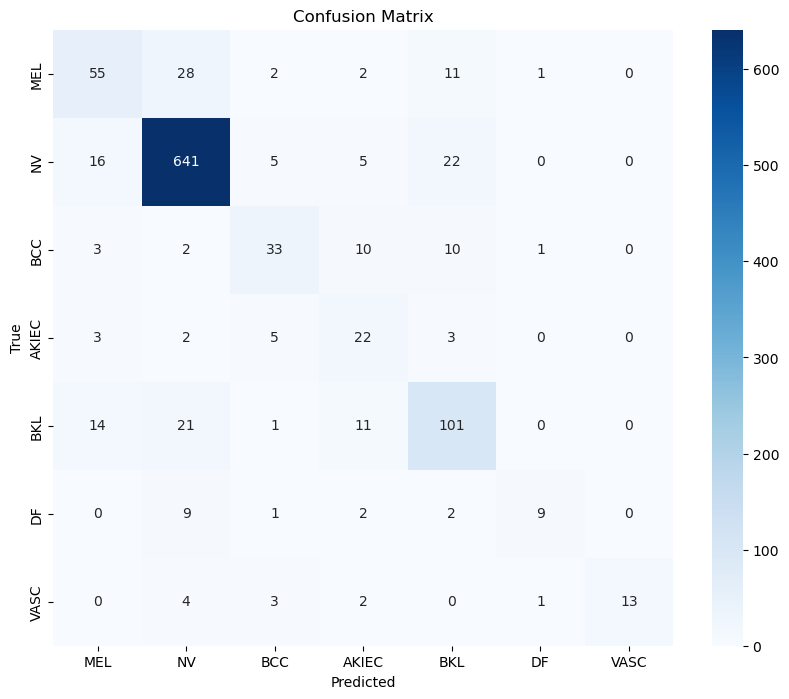

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
# Have already defined class_names

# Plot the confusion matrix
plot_confusion_matrix(results['confusion_matrix'], classes=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

# ROC Curves

In [ ]:
probabilities = []

model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

# Convert probabilities to numpy array
probabilities = np.array(probabilities)

### Compute ROC curve and ROC area for each class

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = 7
# Convert true labels to one-hot encoded format
y_test = label_binarize(test_dataset.img_labels.iloc[:, 1:].values, classes=range(n_classes))
y_score = np.array(probabilities)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


## Plot ROC Curve

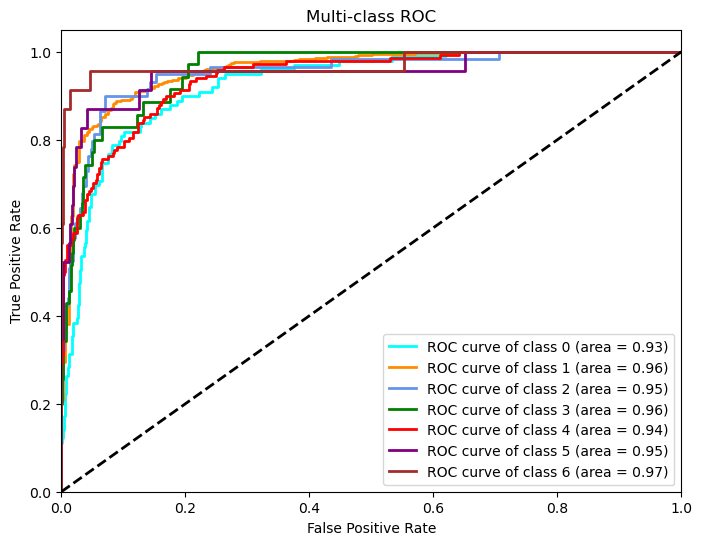

In [ ]:
# Plotting all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


## Installing Packages

In [ ]:
pip install torchviz

In [ ]:
pip install onnx

In [ ]:
pip install onnxruntime

In [ ]:
pip install pydot

# Model Workflow Diagram

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle, Polygon
from matplotlib.lines import Line2D

# Defines the architecture of the model
architecture = [
    {'layer_type': 'Start/End', 'description': 'Start'},
    {'layer_type': 'Input/Output', 'description': 'Load dataset'},
    {'layer_type': 'Input/Output', 'description': 'Deal with imbalanced data'},
    {'layer_type': 'Input/Output', 'description': 'Display some data'},
    {'layer_type': 'Input/Output', 'description': 'Load data'},
    {'layer_type': 'Input/Output', 'description': 'Hyperparameters'},
    {'layer_type': 'Process/Activity', 'description': 'Training loop'},
    {'layer_type': 'Process/Activity', 'description': 'Model training'},
    {'layer_type': 'Process/Activity', 'description': 'Evaluation'},
    {'layer_type': 'Process/Activity', 'description': 'Confusion matrix'},
    {'layer_type': 'Process/Activity', 'description': 'ROC Curve'},
    {'layer_type': 'Start/End', 'description': 'End'}
]

# Create a flowchart diagram of the model architecture
def create_model_flowchart(architecture):
    fig, ax = plt.subplots(figsize=(12, 8))

    x, y = 0.1, 0.9  # Initial position for the first layer
    spacing = 0.1  # Spacing between layers

    for layer in architecture:
        layer_type = layer['layer_type']
        description = layer['description']

        if layer_type == 'Start/End':
            ax.add_patch(Ellipse((x + 0.1, y - 0.025), 0.1, 0.05, facecolor='skyblue', edgecolor='black', linewidth=2))
            ax.text(x + 0.1, y - 0.025, description, ha='center', va='center', fontsize=12, fontweight='bold')
        elif layer_type == 'Input/Output':
            ax.add_patch(Polygon([(x, y), (x + 0.2, y), (x + 0.1, y - 0.05)], closed=True, facecolor='lightgreen', edgecolor='black', linewidth=2))
            ax.text(x + 0.1, y + 0.025, description, ha='center', va='center', fontsize=12, fontweight='bold')
        elif layer_type == 'Process/Activity':
            ax.add_patch(Rectangle((x, y), 0.2, 0.05, facecolor='lightgrey', edgecolor='black', linewidth=2))
            ax.text(x + 0.1, y + 0.025, description, ha='center', va='center', fontsize=12, fontweight='bold')

        y -= spacing

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    ax.axis('off')
    plt.title('Model Workflow', fontsize=16, fontweight='bold', color='navy')
    plt.show()

# Creates the flowchart diagram
create_model_flowchart(architecture)